In [1]:
import os
import json
import numpy as np
import pandas as pd

from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
from sentence_transformers import SentenceTransformer

In [3]:
# defining relative paths
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))
data_dir = os.path.join(parent_dir, "Data")

In [15]:
train_df = pd.read_csv(os.path.join(data_dir, 'train_english_cleaned_without_mentions.tsv'), delimiter='\t')
test_df = pd.read_csv(os.path.join(data_dir, 'test_english_cleaned_without_mentions.tsv'), delimiter='\t')

In [16]:
clustering_df = train_df.copy()
fold_prefix = "train"
embedding_column = "sentence_embeddings"
embedding_label_column = "Cluster_st_Kmeans"


### Calculating Embeddings

In [7]:
model = SentenceTransformer('roberta-large')

No sentence-transformers model found with name C:\Users\cemul/.cache\torch\sentence_transformers\roberta-large. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at C:\Users\cemul/.cache\torch\sentence_transformers\roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def get_SentenceTransformer_Embeddinngs(text):
    return model.encode(text)

In [18]:
clustering_df[embedding_column] = clustering_df['tweet_text'].apply(get_SentenceTransformer_Embeddinngs)

In [19]:
clustering_df

,tweet_text,check_worthiness,sentence_embeddings
0,Since this will never get reported by the medi...,1,"[-0.06967484, 0.009156072, -0.3161755, -0.0311..."
1,"Thanks, MichaelBloomberg. Here’s a handy littl...",0,"[-0.092803024, 0.07203515, -0.29511964, -0.082..."
2,"Folks, when you say ""The COVID-19 isn't a big ...",0,"[0.017074648, -0.01155715, -0.3441132, -0.0142..."
3,Just 1 case of COVID-19 in India and people ar...,0,"[-0.0026251401, -0.13153537, -0.25313452, -0.0..."
4,President made a commitment to donate his sala...,1,"[-0.11462191, -0.032779604, -0.31262833, -0.02..."
...,...,...,...
817,Stop spreading fake news COVID-19,0,"[0.03876098, -0.18901499, -0.07716939, 0.06252..."
818,It's fake! It's fake!' shout residents of a co...,1,"[0.007642734, -0.027167486, -0.24060212, -0.04..."
819,Be Smart about COVID-19: 1⃣ follow accurate pu...,0,"[-0.107051894, -0.10550421, -0.2770136, -0.192..."
820,"On the left: , a Qatari puppet, attacks Saudi ...",1,"[-0.025691662, -0.10346046, -0.2387203, -0.049..."


### Dimentionality Reduction

In [20]:
embeddings_list = clustering_df[embedding_column].tolist()
label_list = clustering_df['check_worthiness'].tolist()

c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\cemul\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


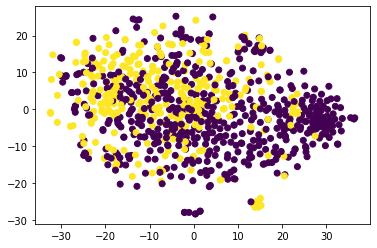

In [21]:

tsne = TSNE(n_components=2, random_state=42)
tsne_points = tsne.fit_transform(embeddings_list)
plt.scatter(tsne_points[:, 0], tsne_points[:, 1], c=label_list)

#for label, x, y in zip(label_list, tsne_points[:, 0], tsne_points[:, 1]):
#    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords="offset points")
plt.show()

In [22]:
mapping2D = tsne_points

#### K-means Clustering

In [25]:
# cluster_df = pd.DataFrame(...)
cluster_df = pd.DataFrame(mapping2D)

In [24]:
mapping2D

array([[-23.204235 ,  -3.786337 ],
       [  5.937955 ,  -5.2549524],
       [ -9.377744 ,  -6.506589 ],
       ...,
       [-10.937782 , -17.325521 ],
       [  5.474787 ,  -1.7747457],
       [-13.912794 , -18.184933 ]], dtype=float32)

In [26]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(embeddings_list)
    distortions.append(kmeanModel.inertia_)

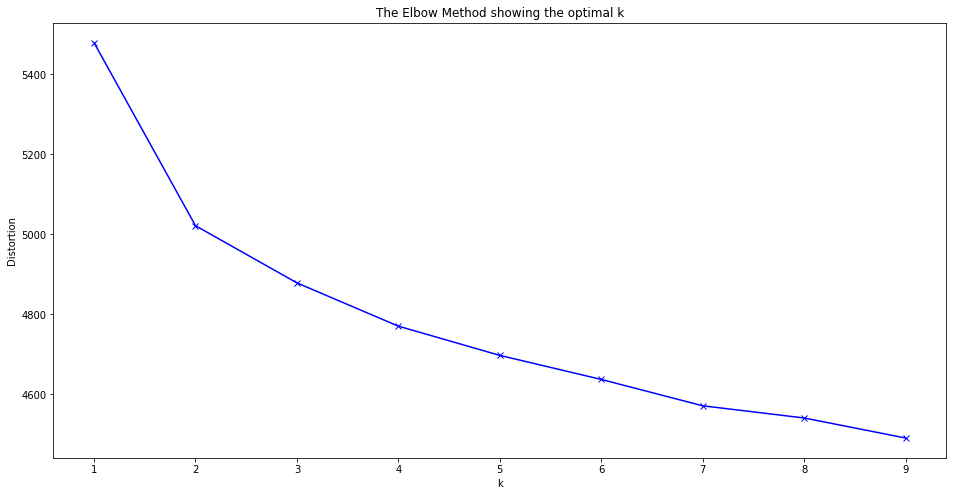

In [27]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [28]:
kmeanModel = KMeans(n_clusters=2)
kmeanModel.fit(embeddings_list)

cluster_predictions = kmeanModel.predict(embeddings_list)

Text(0.5, 1.0, 'K_Means')

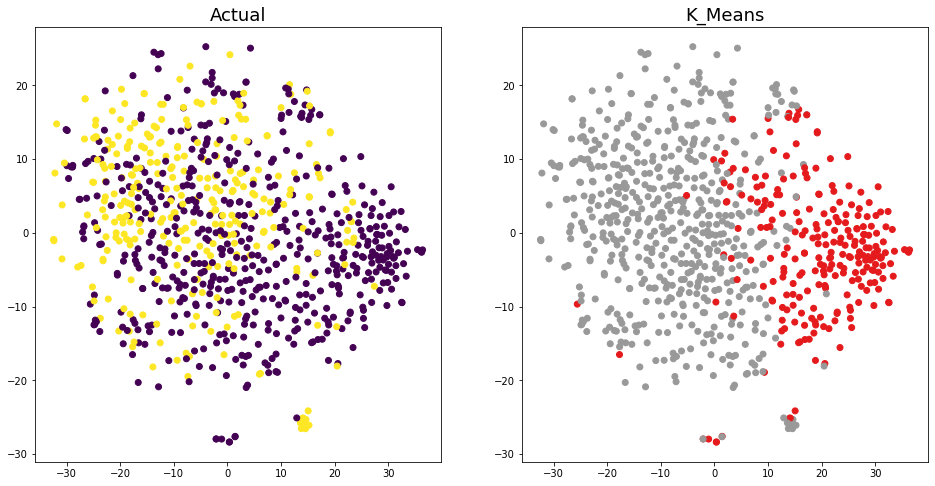

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].scatter(cluster_df[0], cluster_df[1], c=label_list)
axes[1].scatter(cluster_df[0], cluster_df[1], c=cluster_predictions, cmap=plt.cm.Set1)
axes[0].set_title('Actual', fontsize=18)
axes[1].set_title('K_Means', fontsize=18)

In [33]:
clustering_df[embedding_label_column] = cluster_predictions

In [34]:
clustering_df

,tweet_text,check_worthiness,sentence_embeddings,Cluster_st_Kmeans
0,Since this will never get reported by the medi...,1,"[-0.06967484, 0.009156072, -0.3161755, -0.0311...",1
1,"Thanks, MichaelBloomberg. Here’s a handy littl...",0,"[-0.092803024, 0.07203515, -0.29511964, -0.082...",1
2,"Folks, when you say ""The COVID-19 isn't a big ...",0,"[0.017074648, -0.01155715, -0.3441132, -0.0142...",1
3,Just 1 case of COVID-19 in India and people ar...,0,"[-0.0026251401, -0.13153537, -0.25313452, -0.0...",1
4,President made a commitment to donate his sala...,1,"[-0.11462191, -0.032779604, -0.31262833, -0.02...",1
...,...,...,...,...
817,Stop spreading fake news COVID-19,0,"[0.03876098, -0.18901499, -0.07716939, 0.06252...",0
818,It's fake! It's fake!' shout residents of a co...,1,"[0.007642734, -0.027167486, -0.24060212, -0.04...",1
819,Be Smart about COVID-19: 1⃣ follow accurate pu...,0,"[-0.107051894, -0.10550421, -0.2770136, -0.192...",1
820,"On the left: , a Qatari puppet, attacks Saudi ...",1,"[-0.025691662, -0.10346046, -0.2387203, -0.049...",1


In [35]:
clustering_df[clustering_df[embedding_label_column]==0].check_worthiness.value_counts()

0    209
1     39
Name: check_worthiness, dtype: int64

In [37]:
clustering_df[clustering_df[embedding_label_column]==1].check_worthiness.value_counts()

0    323
1    251
Name: check_worthiness, dtype: int64

In [38]:
clustering_df[clustering_df[embedding_label_column]==0][["tweet_text", "check_worthiness", "Cluster_st_Kmeans"]]

,tweet_text,check_worthiness,Cluster_st_Kmeans
11,Countries with largest numbers of COVID-19 dia...,0,0
15,Nigeria being able to handle Ebola and COVID-1...,0,0
17,Now they want to clean,0,0
30,Thank you for the inspiration India- from toda...,0,0
34,We are doomed. COVID-19 COVID-19,0,0
...,...,...,...
804,5 Mar 20 | 7pm GMT+2 of confirmed COVID-19 cas...,0,0
807,Still rumors are more contagious than COVID-19...,0,0
809,COVID-19 conspiracy? Iranian commander suggest...,1,0
812,Trump just reversed the Obama administration a...,1,0


In [65]:
# clustering_df[["tweet_text", "check_worthiness", "Cluster_st_Kmeans"]].to_csv("train_clustered.csv", encoding='utf-8', index=False)

Labels:

0 => short informal

1 => long formal

### Stratified Sampling According to clusters and labels

In [49]:
n_fold = 6
random_seed = 42



In [40]:
def fold_for_label(df: pd.DataFrame, fold_count, random_state):
    # Group positive and negative samples for stratified sampling
    sampling_df = df.sample(frac=1, replace=False, random_state=random_state)
    sampling_negative_df = sampling_df[sampling_df['check_worthiness']==0]
    sampling_positive_df = sampling_df[sampling_df['check_worthiness']==1]

    #determine fold length for both classes
    fold_size_for_negatives = sampling_negative_df.shape[0]//fold_count
    fold_size_for_positives = sampling_positive_df.shape[0]//fold_count

    fold_list = []
    for i in range(fold_count):
        lower_bound_positives = fold_size_for_positives*i
        upper_bound_positives = fold_size_for_positives * (i+1)
        
        lower_bound_negatives = fold_size_for_negatives*i
        upper_bound_negatives = fold_size_for_negatives * (i+1)

        if i+1 == fold_count:
            upper_bound_positives = None
            upper_bound_negatives = None

        fold_for_negatives = sampling_negative_df.iloc[lower_bound_negatives : upper_bound_negatives]
        fold_for_positives = sampling_positive_df.iloc[lower_bound_positives : upper_bound_positives]
        fold_df = pd.concat([fold_for_negatives, fold_for_positives]).sample(frac=1, replace=False, random_state=random_state)

        fold_list.append(fold_df)

    return fold_list

In [41]:
cluster_label_list = clustering_df[embedding_label_column].unique()
cluster_label_list

array([1, 0])

In [42]:
print(clustering_df[clustering_df[embedding_label_column] ==0].shape)
print(clustering_df[clustering_df[embedding_label_column] ==1].shape)


(248, 4)
(574, 4)


In [43]:
clustering_df.head(3)

,tweet_text,check_worthiness,sentence_embeddings,Cluster_st_Kmeans
0,Since this will never get reported by the medi...,1,"[-0.06967484, 0.009156072, -0.3161755, -0.0311...",1
1,"Thanks, MichaelBloomberg. Here’s a handy littl...",0,"[-0.092803024, 0.07203515, -0.29511964, -0.082...",1
2,"Folks, when you say ""The COVID-19 isn't a big ...",0,"[0.017074648, -0.01155715, -0.3441132, -0.0142...",1


In [44]:
upper_fold_list = []
for cluster_label in cluster_label_list:
    cluster_df = clustering_df[clustering_df[embedding_label_column] ==cluster_label]
    cluster_fold_list = fold_for_label(cluster_df, n_fold, random_state=random_seed)
    upper_fold_list.append(cluster_fold_list)
    print(cluster_df.shape)

(574, 4)
(248, 4)


In [45]:
ulist = list(map(list, zip(*upper_fold_list)))

In [51]:
fold_list = []
for i in range(n_fold):
    fold_file_path = os.path.join(data_dir, f"clustered_{fold_prefix}_fold{i+1}.csv")
    print(fold_file_path)
    #fold_list.append(pd.concat(ulist[i]))

c:\repos\Transformers_For_Claim_Worthiness\Data\clustered_train_fold1.csv
c:\repos\Transformers_For_Claim_Worthiness\Data\clustered_train_fold2.csv
c:\repos\Transformers_For_Claim_Worthiness\Data\clustered_train_fold3.csv
c:\repos\Transformers_For_Claim_Worthiness\Data\clustered_train_fold4.csv
c:\repos\Transformers_For_Claim_Worthiness\Data\clustered_train_fold5.csv
c:\repos\Transformers_For_Claim_Worthiness\Data\clustered_train_fold6.csv


In [53]:
test_fold = pd.concat(ulist[5])

In [137]:
fold_list[5].shape

(152, 4)

In [55]:
test_fold

,tweet_text,check_worthiness,sentence_embeddings,Cluster_st_Kmeans
234,Everyone can help prevent the spread of COVID-...,0,"[-0.02336105, -0.10648944, -0.32791814, 0.0159...",1
582,This is RITM Director Dr. Celia Carlos who was...,1,"[-0.03923752, -0.005113996, -0.28285736, -0.04...",1
229,BREAKTHROUGH: Chloroquine phosphate -- an old ...,1,"[0.09154935, -0.17955889, -0.39640155, 0.02528...",1
23,Dear Pence: What are you hiding from the Ameri...,0,"[-0.038692944, 0.06244933, -0.27391502, -0.184...",1
488,Yesterday I knocked on my Tennant's door and t...,0,"[0.06476772, -0.055548437, -0.30830666, -0.035...",1
...,...,...,...,...
199,Exhibit A 🥴,0,"[0.089751445, -0.18046752, -0.2673865, 0.15454...",0
570,Y’all dirty mfs brought COVID-19 home from Mia...,1,"[-0.07048907, 0.1249845, -0.19876929, -0.14427...",0
778,Always an alterior motive with NancyPelosi Ada...,0,"[-0.13056484, 0.0195819, -0.279423, -0.0693676...",0
250,"Extraordinary really, how Russia doesn’t have ...",0,"[-0.057742022, -0.042800624, -0.24430914, -0.0...",0


In [138]:
fold_list[5]

,tweet_text,check_worthiness,sentence_embeddings,Cluster_st_Kmeans
234,Everyone can help prevent the spread of COVID-...,0,"[-0.02336105, -0.10648944, -0.32791814, 0.0159...",1
582,This is RITM Director Dr. Celia Carlos who was...,1,"[-0.03923752, -0.005113996, -0.28285736, -0.04...",1
229,BREAKTHROUGH: Chloroquine phosphate -- an old ...,1,"[0.09154935, -0.17955889, -0.39640155, 0.02528...",1
23,Dear Pence: What are you hiding from the Ameri...,0,"[-0.038692944, 0.06244933, -0.27391502, -0.184...",1
488,Yesterday I knocked on my Tennant's door and t...,0,"[0.06476772, -0.055548437, -0.30830666, -0.035...",1
...,...,...,...,...
199,Exhibit A 🥴,0,"[0.089751445, -0.18046752, -0.2673865, 0.15454...",0
570,Y’all dirty mfs brought COVID-19 home from Mia...,1,"[-0.07048907, 0.1249845, -0.19876929, -0.14427...",0
778,Always an alterior motive with NancyPelosi Ada...,0,"[-0.13056484, 0.0195819, -0.279423, -0.0693676...",0
250,"Extraordinary really, how Russia doesn’t have ...",0,"[-0.057742022, -0.042800624, -0.24430914, -0.0...",0


In [81]:
type(upper_fold_list)

list

In [82]:
len(upper_fold_list)

2

In [83]:
type(upper_fold_list[0])

list

In [84]:
len(upper_fold_list[0])

6

In [85]:
type(upper_fold_list[0][0])

pandas.core.frame.DataFrame

In [89]:
upper_fold_list[0][2].shape

(94, 4)

In [105]:
type(ulist)

list

In [106]:
len(ulist)

6

In [107]:
type(ulist[0])

list

In [108]:
len(ulist[0])

2

In [109]:
type(ulist[0][0])

pandas.core.frame.DataFrame

In [113]:
ulist[1][1].shape

(40, 4)

In [95]:
len(ulist[0][0])

6

In [96]:
type(ulist[0][0][0])

pandas.core.frame.DataFrame

In [103]:
ulist[0][0][4].shape

(94, 4)

In [ ]:
for i in range(len(cluster_label_list)):
    cluster_label_list[i].pop()

In [64]:
type(upper_fold_list[0])

IndexError: list index out of range

In [56]:
cluster_fold_list[3].shape

(40, 4)

In [63]:
upper_fold_list.pop()

[                                            tweet_text  check_worthiness  \
 745  So there is local transmission. Please wash yo...                 0   
 119  the fact that one way tickets to italy are lik...                 0   
 786  FOX to cause PANDEMIC FoxNews is spreading Tru...                 1   
 806  COVID-19 test in US is $3,000. Here in Tokyo i...                 1   
 81   The COVID-19 Outbreak shows how important it i...                 0   
 ..                                                 ...               ...   
 84   - China failed to develop medication for COVID...                 1   
 478  A frustrated doctor eventually told us that my...                 1   
 89   My wife and I get COVID-19. We go to Disneylan...                 0   
 9    Dear : You knew about COVID-19 in January. It ...                 1   
 750  So here’s a question for today: if you are a d...                 0   
 
                                    sentence_embeddings  Cluster_st_Kmeans